## Data Preprocessing & Exploration

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("nyc-taxi-analysis") \
        .getOrCreate()
        
df_trip_data = spark.read.csv("/root/DevDataOps/Datasets/taxi_analysis/taxi_trip_data.csv", header=True, inferSchema=True)
df_zone_geo  = spark.read.csv("/root/DevDataOps/Datasets/taxi_analysis/taxi_zone_geo.csv", header=True, inferSchema=True) 

print(f"Taxi Trip Data\n")
df_trip_data.show(5)
print("="*200)
print("Taxi Zone Geo Data\n")
df_zone_geo.show(5)


your 131072x1 screen size is bogus. expect trouble
25/05/21 02:03:39 WARN Utils: Your hostname, DESKTOP-L4AHF1L resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/05/21 02:03:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/05/21 02:03:39 WARN Utils: Your hostname, DESKTOP-L4AHF1L resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/05/21 02:03:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/21 02:03:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/21 02:03:39 WARN NativeCodeLoader: Unable to load native-hadoo

Taxi Trip Data

+---------+----------------+----------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+
|vendor_id| pickup_datetime|dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|pickup_location_id|dropoff_location_id|
+---------+----------------+----------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+
|        1| 5/11/2018 17:40| 5/11/2018 17:55|              1|          1.6|        1|                 N|           1|       11.5|  1.0|    0.5|       0.0|         0.0|          0.3|                48|                 68|
|        2| 3/22/2018 23:01| 3/22/2018 23:25|              1|         9.52|        1|               

## Data Quality Analysis
Let's first examine the data quality by checking for missing values, outliers, and basic statistics.

Missing Values Analysis - Trip Data:


25/05/21 02:03:50 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+---------+---------------+----------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+
|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|pickup_location_id|dropoff_location_id|
+---------+---------------+----------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+
|        0|              0|               0|              0|            0|        0|                 0|           0|          0|    0|      0|         0|           0|            0|                 0|                  0|
+---------+---------------+----------------+---------------+-------------+---------+------------------+------------+----

Trip Data Statistics:
                         count        mean        std     min     25%     50%  \
pickup_location_id   1048575.0  163.180203  66.534180    1.00  114.00  162.00   
dropoff_location_id  1048575.0  161.383234  70.462862    1.00  107.00  162.00   
fare_amount          1048575.0   12.969129  11.683623 -120.00    6.50    9.50   
trip_distance        1048575.0    2.925554   3.769620    0.00    0.96    1.60   
tip_amount           1048575.0    1.870452   2.642193   -8.02    0.00    1.38   
passenger_count      1048575.0    1.594346   1.240639    0.00    1.00    1.00   
vendor_id            1048575.0    1.589587   0.517299    1.00    1.00    2.00   
payment_type         1048575.0    1.314401   0.484469    1.00    1.00    1.00   
rate_code            1048575.0    1.048141   0.673330    1.00    1.00    1.00   
mta_tax              1048575.0    0.497179   0.050993   -0.50    0.50    0.50   
tolls_amount         1048575.0    0.345995   2.033326  -12.50    0.00    0.00   
extra 

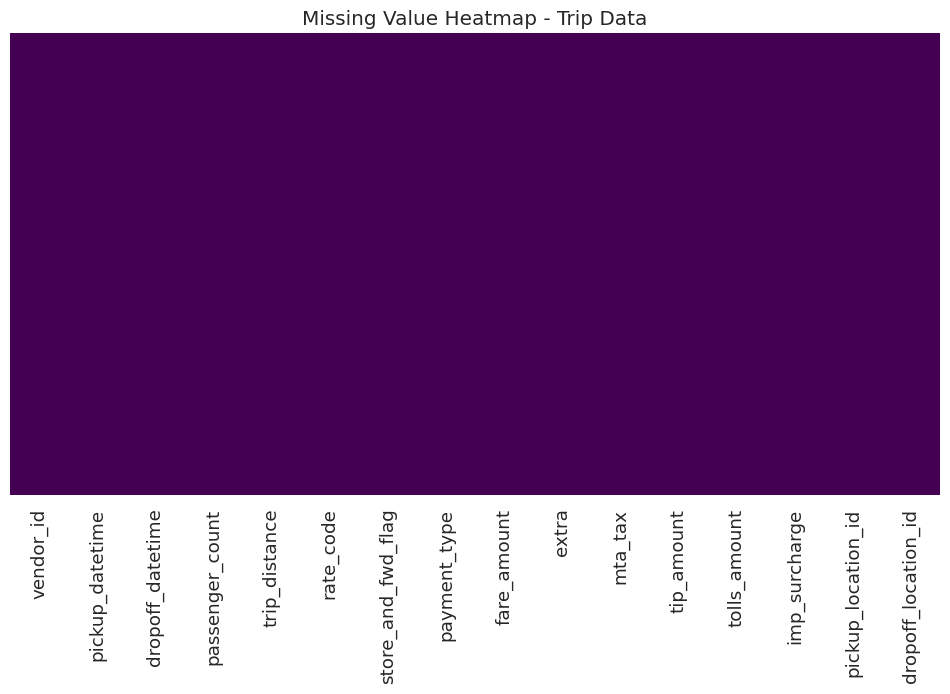

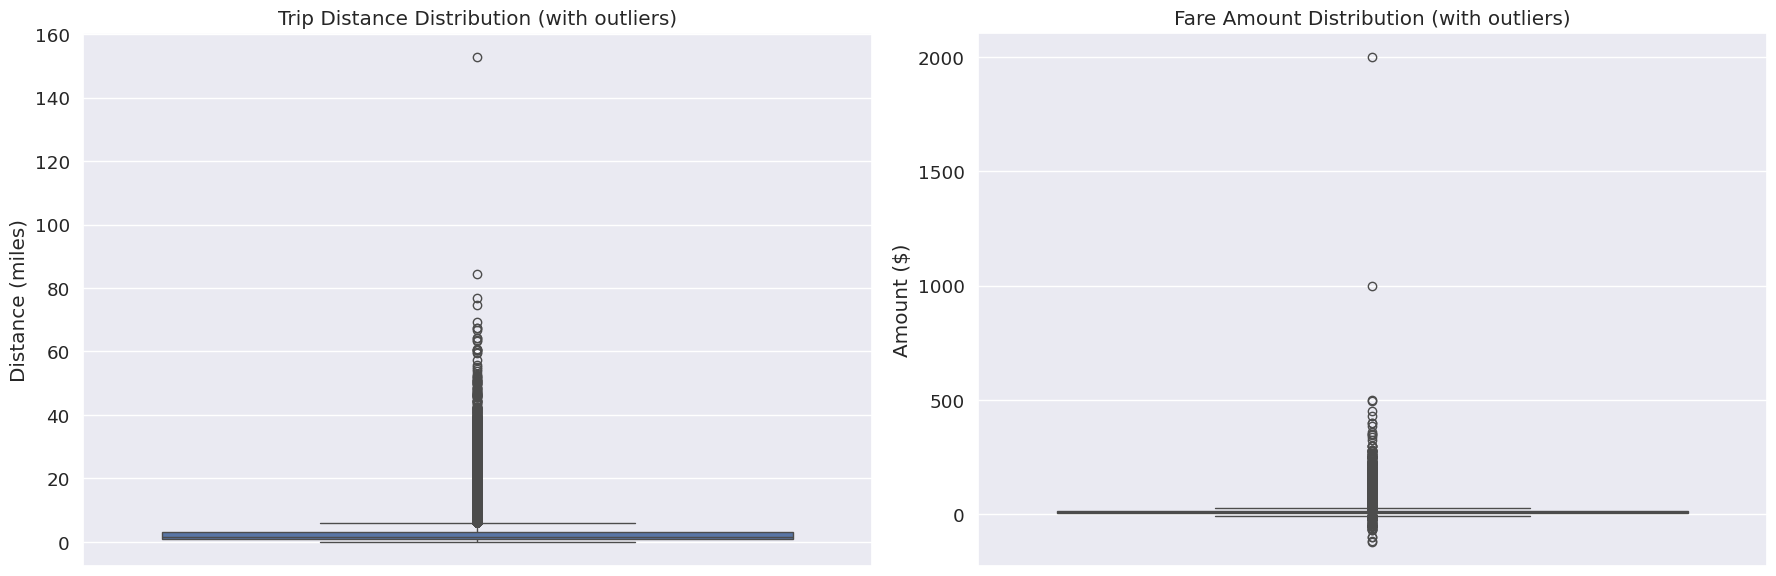


Potential Data Issues:
Negative trip distances: 0
Zero trip distances: 7143
Negative fares: 668
Zero passenger counts: 9408
High passenger counts (>6): 7
Rides with dropoff before pickup: 8
Rides with dropoff before pickup: 8


In [4]:
# Convert to Pandas for easier visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, isnan, when, count

# Set better visualization defaults
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]
sns.set(font_scale=1.2)

# 1. Check for missing values in trip data
print("Missing Values Analysis - Trip Data:")
trip_null_counts = df_trip_data.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df_trip_data.columns])
trip_null_counts.show()

# 2. Check for missing values in zone data
print("Missing Values Analysis - Zone Data:")
zone_null_counts = df_zone_geo.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df_zone_geo.columns])
zone_null_counts.show()

# Convert to pandas for visualization
trip_data_pd = df_trip_data.toPandas()
zone_geo_pd = df_zone_geo.toPandas()

# 3. Check trip_data basic statistics
print("Trip Data Statistics:")
trip_numeric_cols = trip_data_pd.select_dtypes(include=['number']).columns.tolist()
trip_stats = trip_data_pd[trip_numeric_cols].describe().T
print(trip_stats.sort_values('mean', ascending=False))

# 4. Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(trip_data_pd.isnull(), cmap='viridis', yticklabels=False, cbar=False)
plt.title('Missing Value Heatmap - Trip Data')
plt.show()

# 5. Check for outliers in trip distance and fare amount
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Trip distance boxplot
sns.boxplot(y=trip_data_pd['trip_distance'], ax=axes[0])
axes[0].set_title('Trip Distance Distribution (with outliers)')
axes[0].set_ylabel('Distance (miles)')

# Fare amount boxplot
sns.boxplot(y=trip_data_pd['fare_amount'], ax=axes[1])
axes[1].set_title('Fare Amount Distribution (with outliers)')
axes[1].set_ylabel('Amount ($)')

plt.tight_layout()
plt.show()

# 6. Check for invalid data 
print("\nPotential Data Issues:")
print(f"Negative trip distances: {(trip_data_pd['trip_distance'] < 0).sum()}")
print(f"Zero trip distances: {(trip_data_pd['trip_distance'] == 0).sum()}")
print(f"Negative fares: {(trip_data_pd['fare_amount'] < 0).sum()}")
print(f"Zero passenger counts: {(trip_data_pd['passenger_count'] == 0).sum()}")
print(f"High passenger counts (>6): {(trip_data_pd['passenger_count'] > 6).sum()}")

# Check if any rides have dropoff before pickup
try:
    trip_data_pd['pickup_datetime'] = pd.to_datetime(trip_data_pd['pickup_datetime'])
    trip_data_pd['dropoff_datetime'] = pd.to_datetime(trip_data_pd['dropoff_datetime'])
    invalid_times = (trip_data_pd['dropoff_datetime'] < trip_data_pd['pickup_datetime']).sum()
    print(f"Rides with dropoff before pickup: {invalid_times}")
except Exception as e:
    print(f"Could not check datetime validity: {e}")

## Temporal Analysis
Let's analyze patterns in taxi trips over time to understand peak hours, busy days, and seasonal trends.

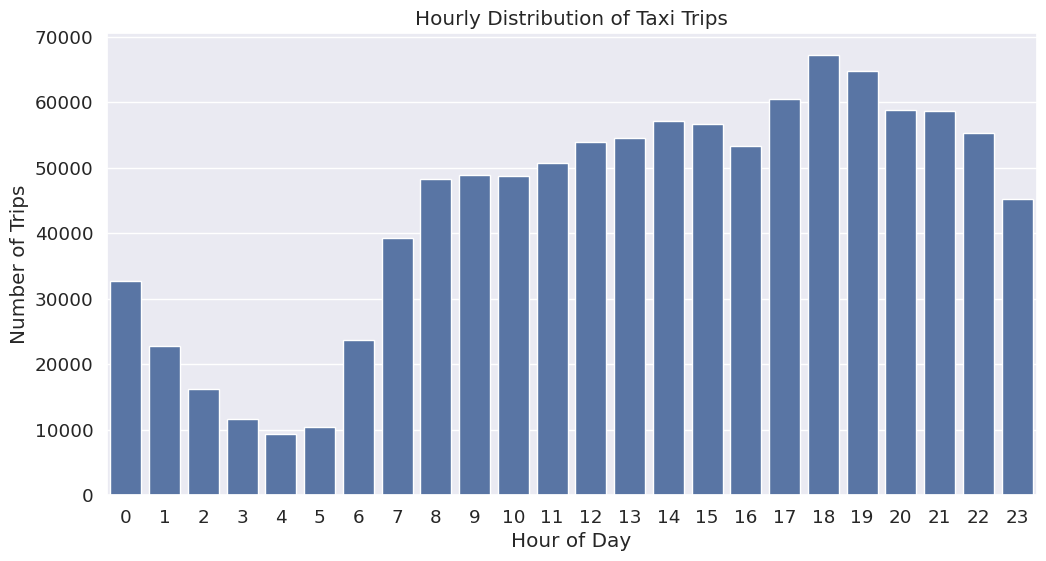

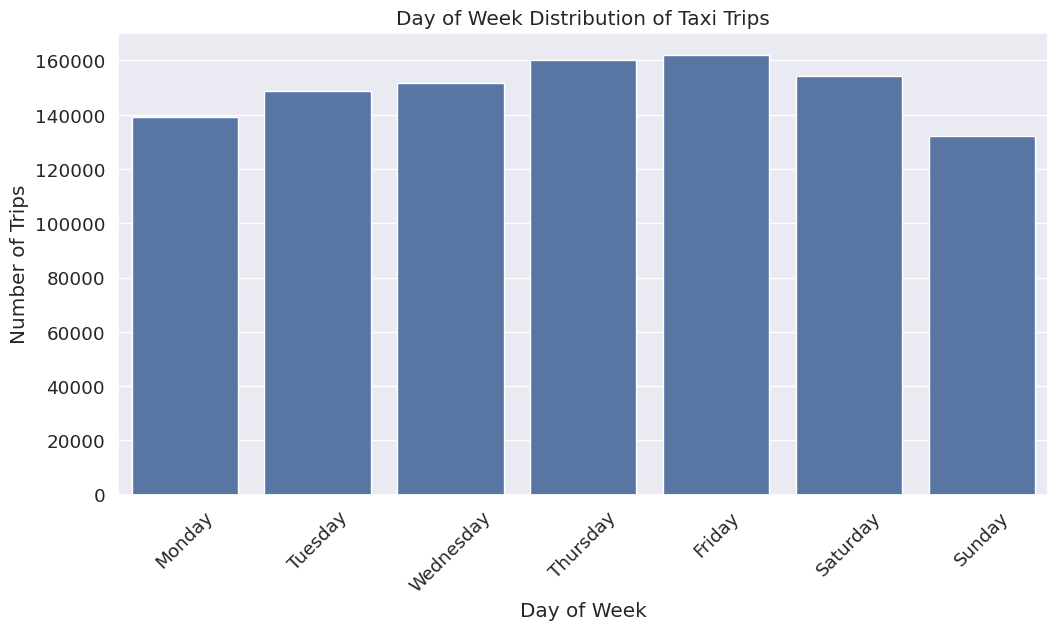

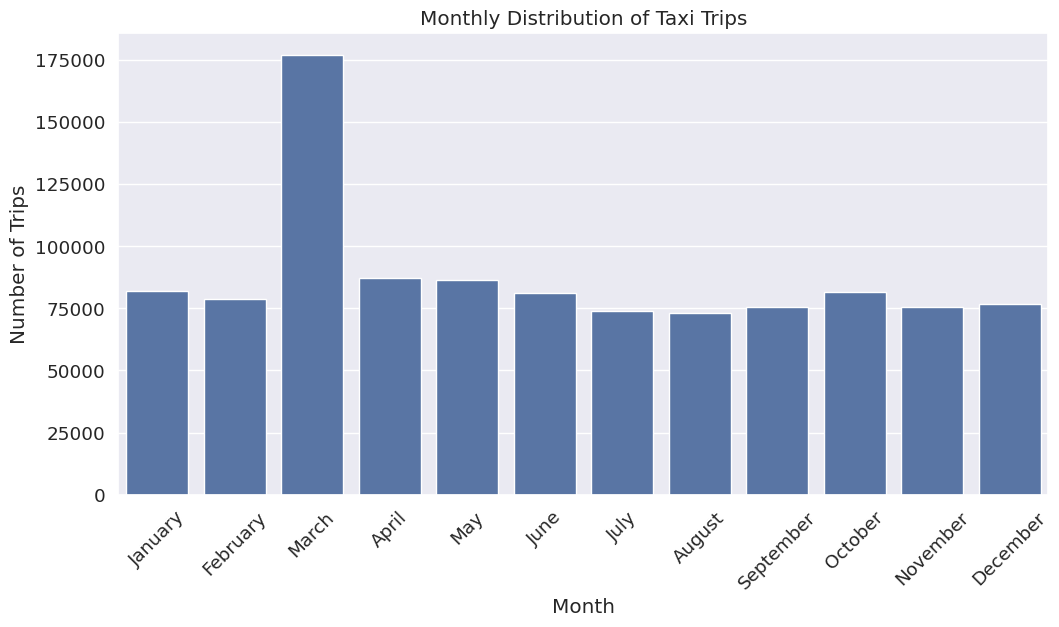

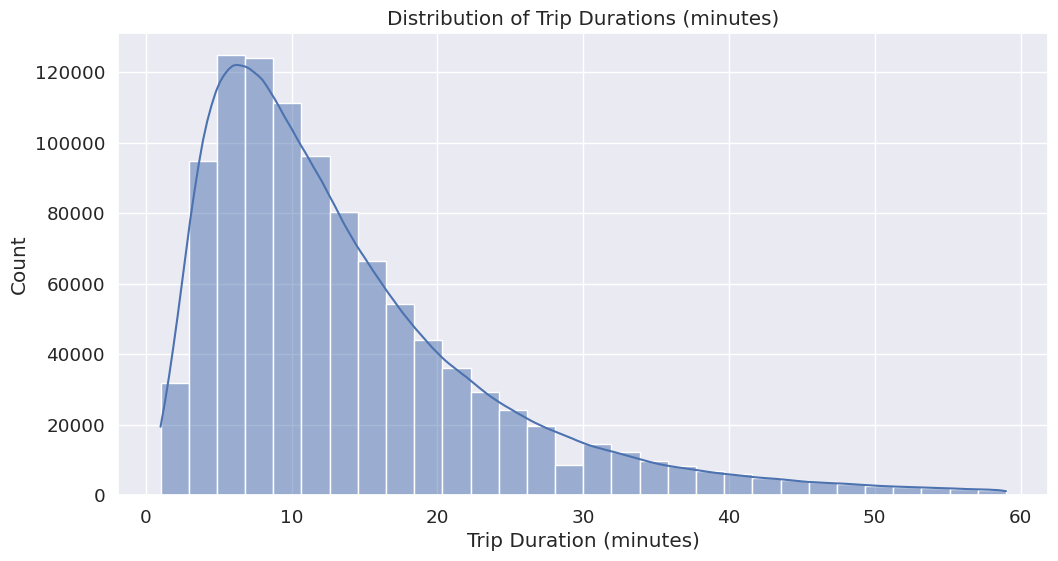

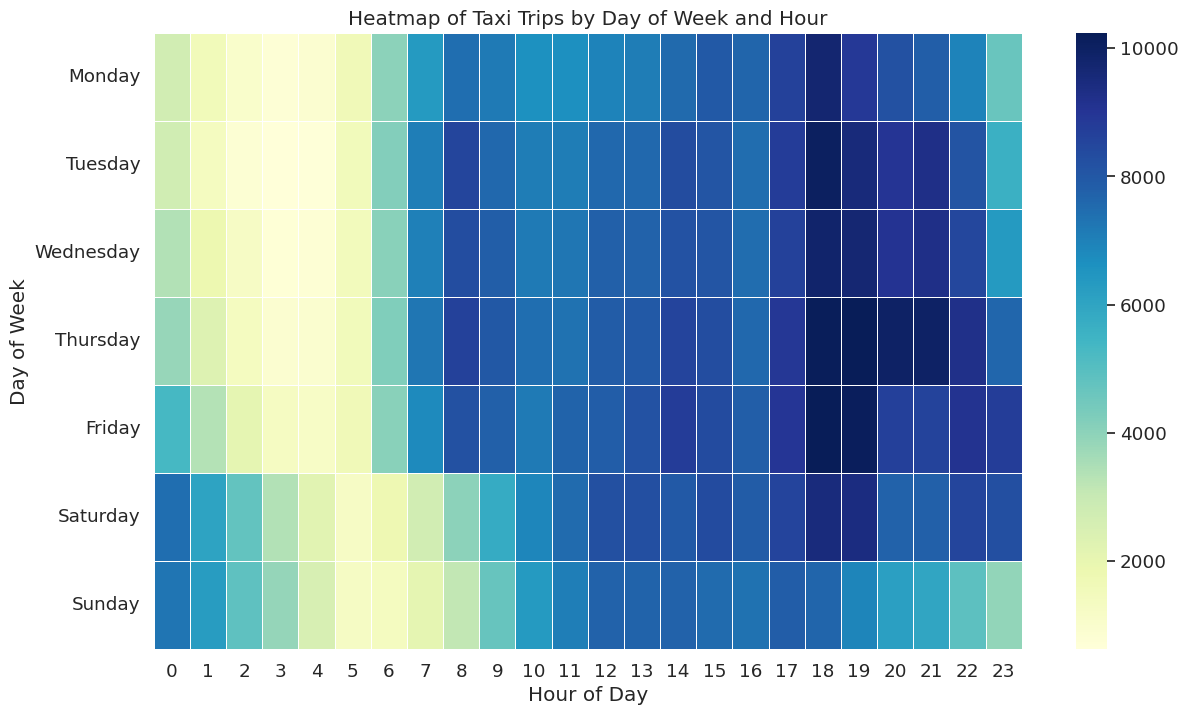

In [5]:
# Extract datetime components
try:
    # Add hour, day of week, and month columns
    trip_data_pd['hour'] = trip_data_pd['pickup_datetime'].dt.hour
    trip_data_pd['day_of_week'] = trip_data_pd['pickup_datetime'].dt.day_name()
    trip_data_pd['month'] = trip_data_pd['pickup_datetime'].dt.month_name()
    
    # Calculate trip duration in minutes
    trip_data_pd['trip_duration_mins'] = (trip_data_pd['dropoff_datetime'] - 
                                         trip_data_pd['pickup_datetime']).dt.total_seconds() / 60
    
    # 1. Hourly trip distribution
    plt.figure(figsize=(12, 6))
    hourly_trips = trip_data_pd['hour'].value_counts().sort_index()
    sns.barplot(x=hourly_trips.index, y=hourly_trips.values)
    plt.title('Hourly Distribution of Taxi Trips')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Trips')
    plt.xticks(range(0, 24))
    plt.show()
    
    # 2. Day of week distribution
    plt.figure(figsize=(12, 6))
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_counts = trip_data_pd['day_of_week'].value_counts()
    day_counts = day_counts.reindex(day_order)
    sns.barplot(x=day_counts.index, y=day_counts.values)
    plt.title('Day of Week Distribution of Taxi Trips')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Trips')
    plt.xticks(rotation=45)
    plt.show()
    
    # 3. Monthly distribution
    plt.figure(figsize=(12, 6))
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    month_counts = trip_data_pd['month'].value_counts()
    month_counts = month_counts.reindex(month_order)
    sns.barplot(x=month_counts.index, y=month_counts.values)
    plt.title('Monthly Distribution of Taxi Trips')
    plt.xlabel('Month')
    plt.ylabel('Number of Trips')
    plt.xticks(rotation=45)
    plt.show()
    
    # 4. Trip duration distribution
    plt.figure(figsize=(12, 6))
    # Filter out extreme outliers for better visualization
    trip_durations = trip_data_pd['trip_duration_mins']
    trip_durations = trip_durations[(trip_durations > 0) & (trip_durations < 60)]  # Trips under 1 hour
    
    sns.histplot(trip_durations, bins=30, kde=True)
    plt.title('Distribution of Trip Durations (minutes)')
    plt.xlabel('Trip Duration (minutes)')
    plt.ylabel('Count')
    plt.show()
    
    # 5. Hourly trip count heatmap by day of week
    plt.figure(figsize=(14, 8))
    day_hour_pivot = pd.crosstab(trip_data_pd['day_of_week'], trip_data_pd['hour'])
    day_hour_pivot = day_hour_pivot.reindex(day_order)
    
    sns.heatmap(day_hour_pivot, cmap='YlGnBu', linewidths=0.5, annot=False)
    plt.title('Heatmap of Taxi Trips by Day of Week and Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.show()
    
except Exception as e:
    print(f"Error in temporal analysis: {e}")

## Geospatial Analysis
Let's analyze the pickup and dropoff locations to understand popular zones and travel patterns.

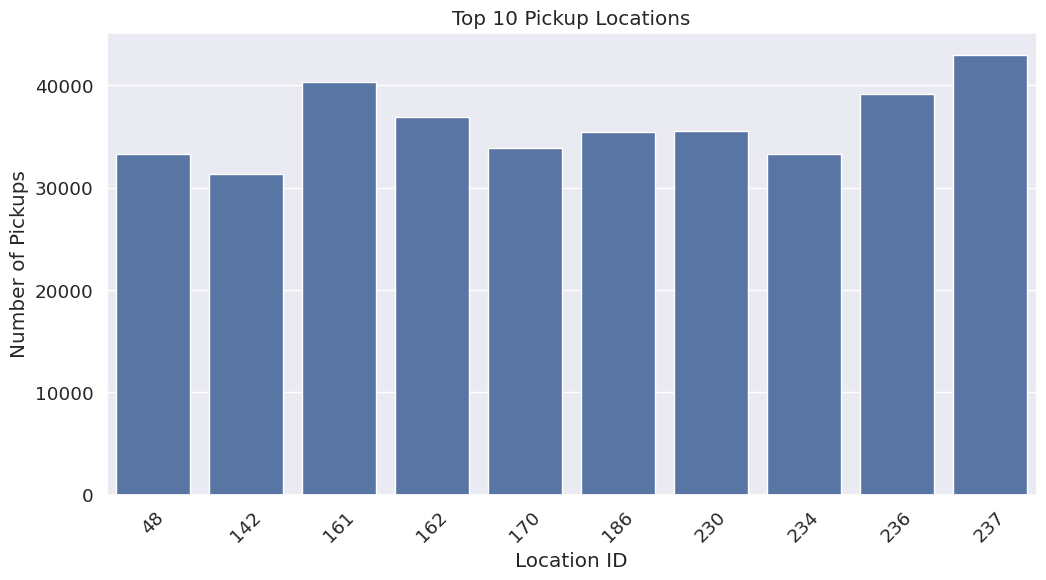

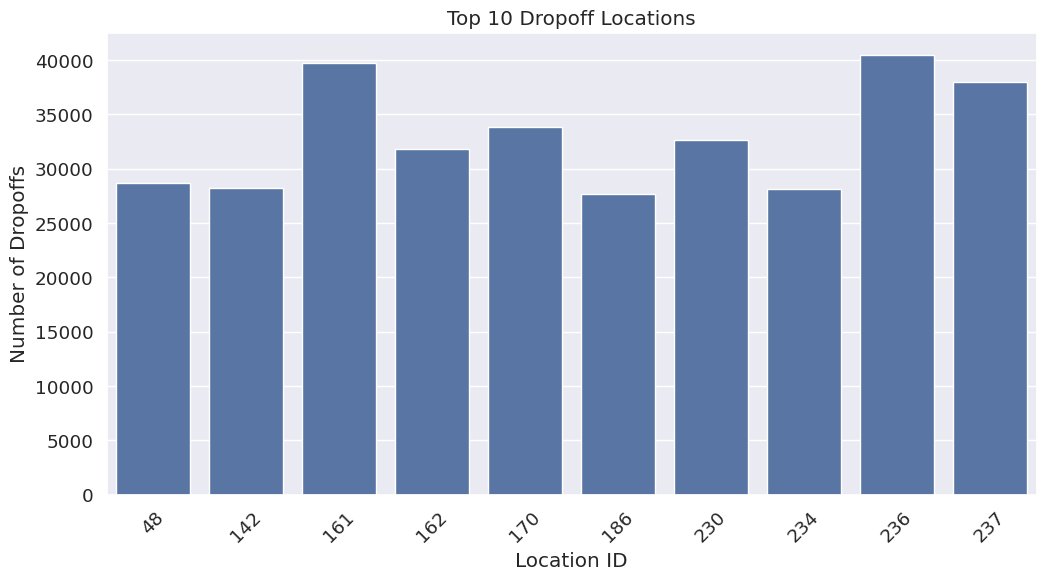

Top 10 Routes:
       pickup_location_id  dropoff_location_id  count
16620                 264                  264  13678
14551                 237                  236   6118
14358                 236                  236   5239
14359                 236                  237   5121
14552                 237                  237   4901
14873                 239                  238   2973
14810                 239                  142   2895
8246                  142                  239   2756
14497                 237                  162   2753
14716                 238                  239   2583
Error in geospatial analysis: 'index'


In [6]:
# Analyze pickup and dropoff locations
try:
    # 1. Top pickup locations
    pickup_counts = trip_data_pd['pickup_location_id'].value_counts().head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=pickup_counts.index, y=pickup_counts.values)
    plt.title('Top 10 Pickup Locations')
    plt.xlabel('Location ID')
    plt.ylabel('Number of Pickups')
    plt.xticks(rotation=45)
    plt.show()
    
    # 2. Top dropoff locations
    dropoff_counts = trip_data_pd['dropoff_location_id'].value_counts().head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=dropoff_counts.index, y=dropoff_counts.values)
    plt.title('Top 10 Dropoff Locations')
    plt.xlabel('Location ID')
    plt.ylabel('Number of Dropoffs')
    plt.xticks(rotation=45)
    plt.show()
    
    # 3. Create a pickup-dropoff matrix for common routes
    routes = trip_data_pd.groupby(['pickup_location_id', 'dropoff_location_id']).size().reset_index(name='count')
    top_routes = routes.sort_values('count', ascending=False).head(10)
    
    print("Top 10 Routes:")
    print(top_routes)
    
    # 4. Check count by borough if that data is available
    if 'borough' in zone_geo_pd.columns:
        # Join with zone data to get borough information
        pickup_zone_data = pd.merge(
            trip_data_pd['pickup_location_id'].value_counts().reset_index(),
            zone_geo_pd[['zone_id', 'borough']],
            left_on='index',
            right_on='zone_id',
            how='left'
        )
        
        # Plot trips by borough
        plt.figure(figsize=(12, 6))
        borough_counts = pickup_zone_data.groupby('borough')['pickup_location_id'].sum()
        sns.barplot(x=borough_counts.index, y=borough_counts.values)
        plt.title('Taxi Pickups by Borough')
        plt.xlabel('Borough')
        plt.ylabel('Number of Pickups')
        plt.xticks(rotation=45)
        plt.show()
        
except Exception as e:
    print(f"Error in geospatial analysis: {e}")

## Correlation Analysis
Let's examine relationships between different variables to understand what factors influence fare amounts.

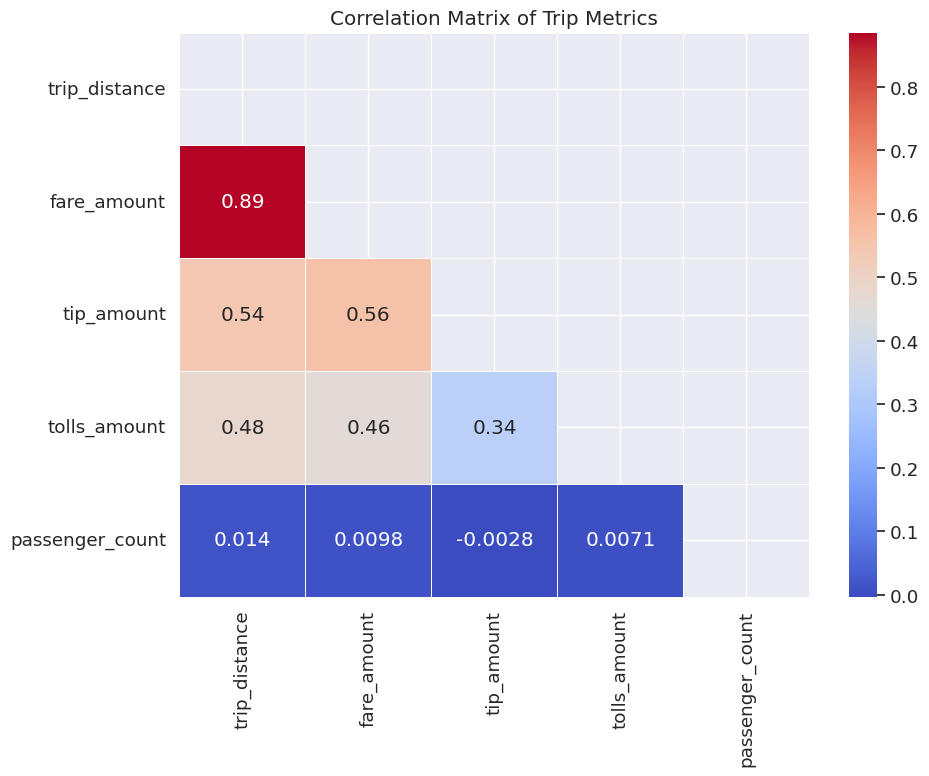

/root/DevDataOps/nyc-taxi-analysis/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


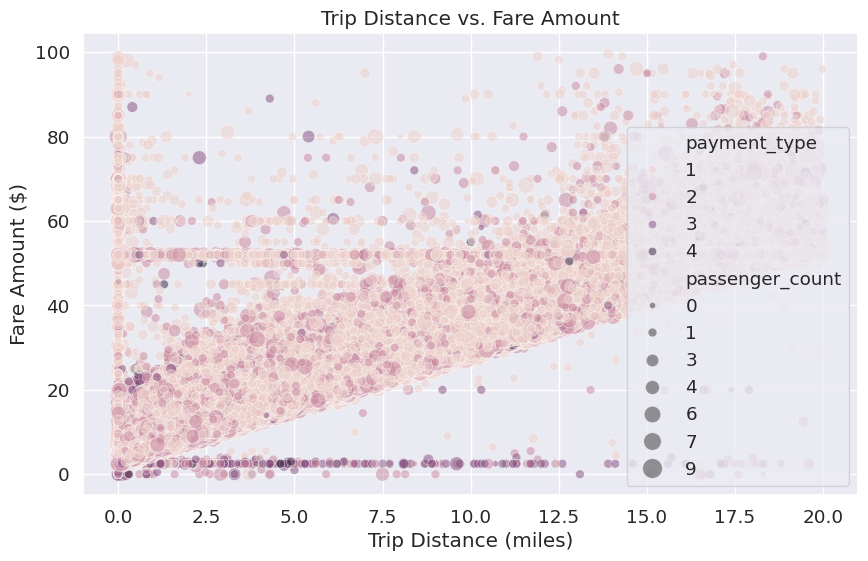

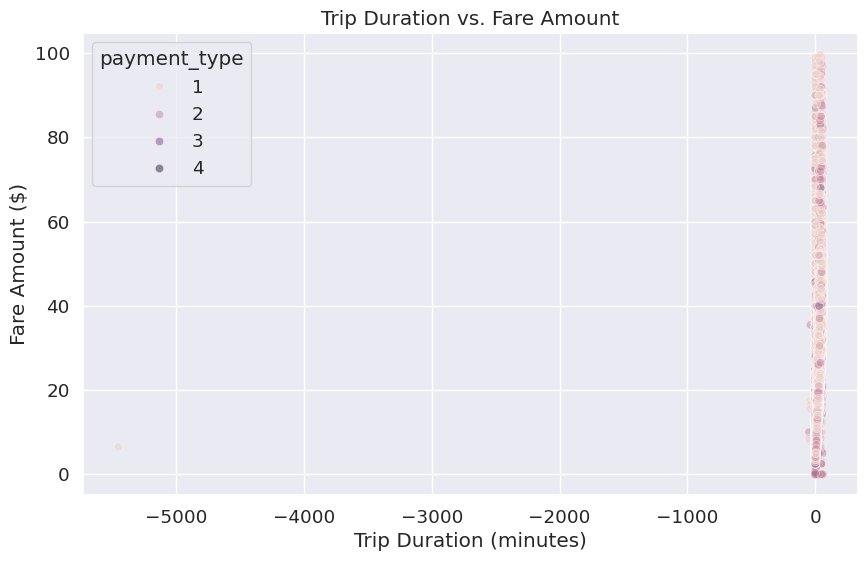

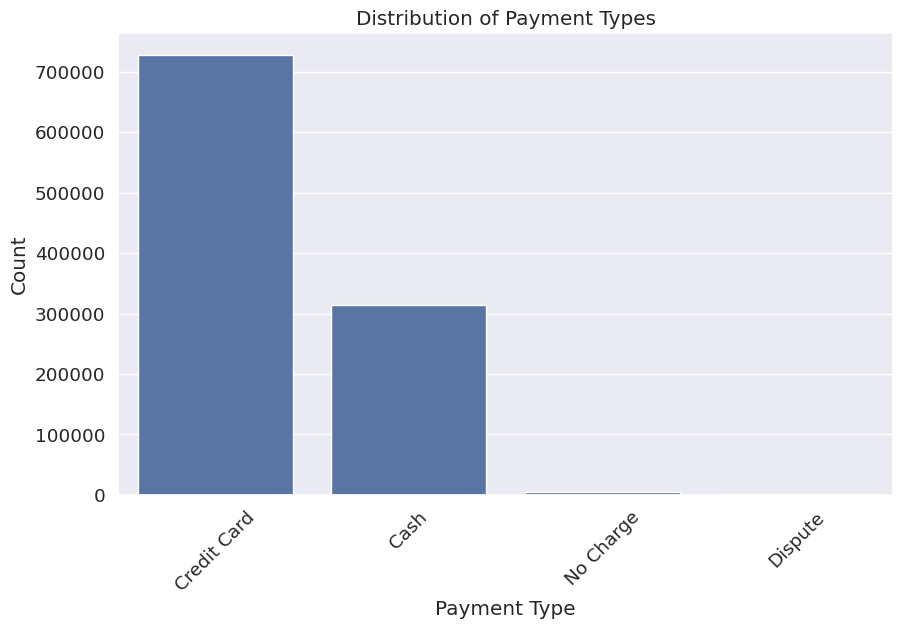

In [7]:
# Analyze correlations between numeric variables
try:
    # Select numeric columns for correlation analysis
    numeric_cols = ['trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 'passenger_count']
    corr_data = trip_data_pd[numeric_cols]
    
    # 1. Correlation matrix
    plt.figure(figsize=(10, 8))
    correlation = corr_data.corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask)
    plt.title('Correlation Matrix of Trip Metrics')
    plt.tight_layout()
    plt.show()
    
    # 2. Scatter plot of trip distance vs. fare amount
    plt.figure(figsize=(10, 6))
    # Filter out extreme outliers for better visualization
    filtered_data = trip_data_pd[
        (trip_data_pd['trip_distance'] < 20) & 
        (trip_data_pd['fare_amount'] < 100) & 
        (trip_data_pd['fare_amount'] > 0)
    ]
    
    sns.scatterplot(
        data=filtered_data, 
        x='trip_distance', 
        y='fare_amount', 
        alpha=0.5, 
        size='passenger_count',
        sizes=(20, 200),
        hue='payment_type'
    )
    plt.title('Trip Distance vs. Fare Amount')
    plt.xlabel('Trip Distance (miles)')
    plt.ylabel('Fare Amount ($)')
    plt.show()
    
    # 3. Relationship between trip duration and fare
    if 'trip_duration_mins' in trip_data_pd.columns:
        plt.figure(figsize=(10, 6))
        filtered_duration_data = trip_data_pd[
            (trip_data_pd['trip_duration_mins'] < 60) & 
            (trip_data_pd['fare_amount'] < 100) & 
            (trip_data_pd['fare_amount'] > 0)
        ]
        
        sns.scatterplot(
            data=filtered_duration_data, 
            x='trip_duration_mins', 
            y='fare_amount', 
            alpha=0.5,
            hue='payment_type'
        )
        plt.title('Trip Duration vs. Fare Amount')
        plt.xlabel('Trip Duration (minutes)')
        plt.ylabel('Fare Amount ($)')
        plt.show()
    
    # 4. Payment type distribution
    plt.figure(figsize=(10, 6))
    payment_counts = trip_data_pd['payment_type'].value_counts()
    
    # Map payment type codes to descriptions if needed
    payment_type_map = {
        1: 'Credit Card',
        2: 'Cash',
        3: 'No Charge',
        4: 'Dispute',
        5: 'Unknown',
        6: 'Voided Trip'
    }
    
    payment_counts_renamed = pd.Series(
        payment_counts.values,
        index=[payment_type_map.get(i, i) for i in payment_counts.index]
    )
    
    sns.barplot(x=payment_counts_renamed.index, y=payment_counts_renamed.values)
    plt.title('Distribution of Payment Types')
    plt.xlabel('Payment Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    
except Exception as e:
    print(f"Error in correlation analysis: {e}")

## Key Performance Indicators
Let's calculate and visualize some key metrics for the taxi business.

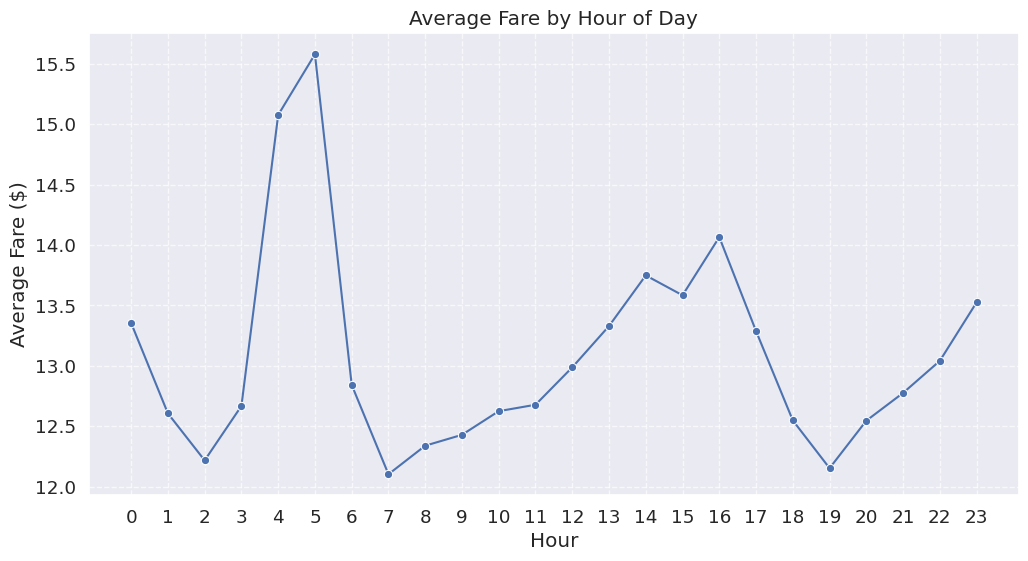

/tmp/ipykernel_64753/1733819548.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tip_by_fare = trip_data_pd.groupby('fare_bin')['tip_percentage'].mean()


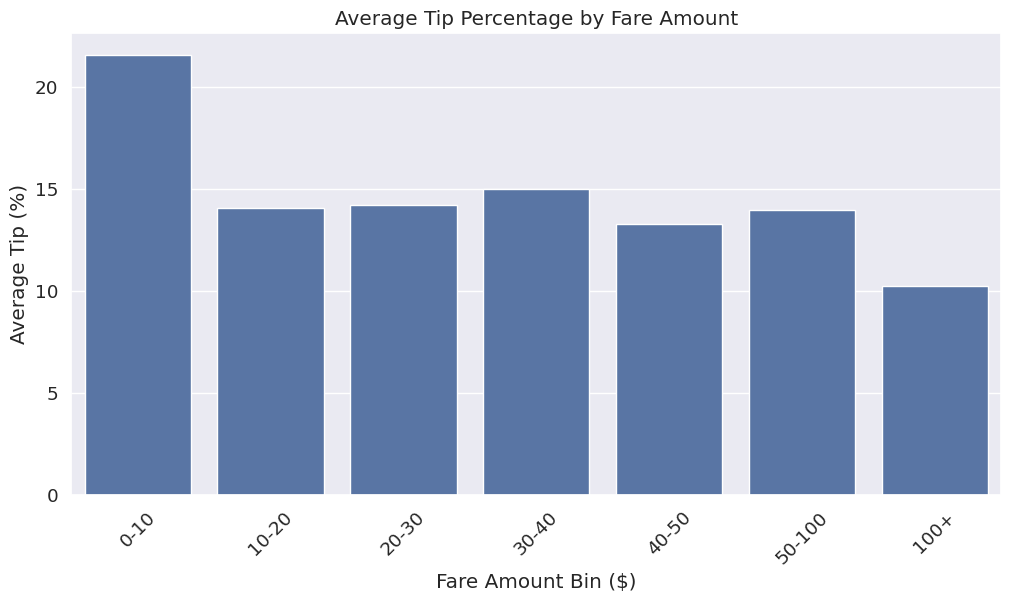

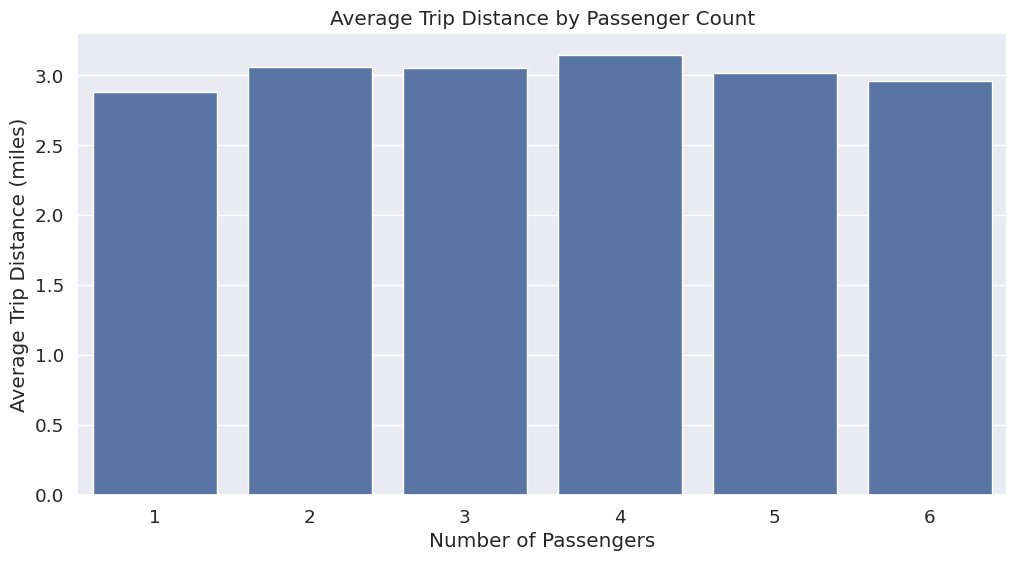

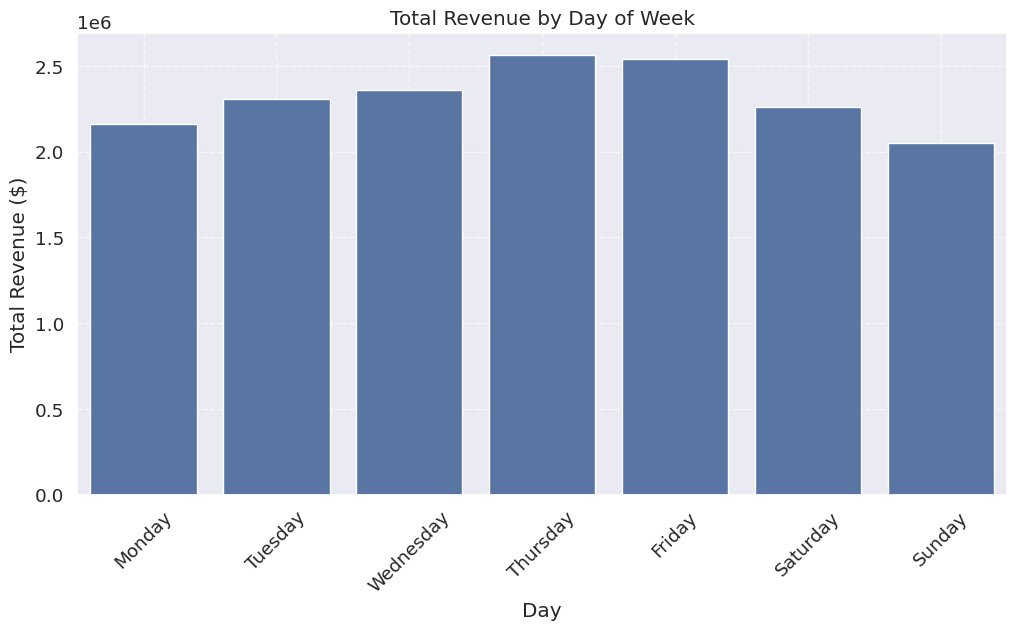

In [8]:
# Calculate and visualize KPIs
try:
    # 1. Average fare by hour of day
    if 'hour' in trip_data_pd.columns:
        plt.figure(figsize=(12, 6))
        hourly_fares = trip_data_pd.groupby('hour')['fare_amount'].mean()
        sns.lineplot(x=hourly_fares.index, y=hourly_fares.values, marker='o')
        plt.title('Average Fare by Hour of Day')
        plt.xlabel('Hour')
        plt.ylabel('Average Fare ($)')
        plt.xticks(range(0, 24))
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
    
    # 2. Average tip percentage by fare amount
    trip_data_pd['tip_percentage'] = np.where(
        trip_data_pd['fare_amount'] > 0,
        100 * trip_data_pd['tip_amount'] / trip_data_pd['fare_amount'],
        0
    )
    
    # Bin the fare amounts
    trip_data_pd['fare_bin'] = pd.cut(
        trip_data_pd['fare_amount'], 
        bins=[0, 10, 20, 30, 40, 50, 100, 1000],
        labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50-100', '100+']
    )
    
    plt.figure(figsize=(12, 6))
    tip_by_fare = trip_data_pd.groupby('fare_bin')['tip_percentage'].mean()
    sns.barplot(x=tip_by_fare.index, y=tip_by_fare.values)
    plt.title('Average Tip Percentage by Fare Amount')
    plt.xlabel('Fare Amount Bin ($)')
    plt.ylabel('Average Tip (%)')
    plt.xticks(rotation=45)
    plt.show()
    
    # 3. Average trip distance by passenger count
    plt.figure(figsize=(12, 6))
    # Filter to reasonable passenger counts (1-6)
    filtered_pass_data = trip_data_pd[trip_data_pd['passenger_count'].between(1, 6)]
    avg_distance_by_passengers = filtered_pass_data.groupby('passenger_count')['trip_distance'].mean()
    
    sns.barplot(x=avg_distance_by_passengers.index, y=avg_distance_by_passengers.values)
    plt.title('Average Trip Distance by Passenger Count')
    plt.xlabel('Number of Passengers')
    plt.ylabel('Average Trip Distance (miles)')
    plt.show()
    
    # 4. Revenue analysis: Calculate total revenue per day
    if 'day_of_week' in trip_data_pd.columns:
        # Total fare = fare + tip + tolls + surcharge
        trip_data_pd['total_revenue'] = (trip_data_pd['fare_amount'] + 
                                       trip_data_pd['tip_amount'] + 
                                       trip_data_pd['tolls_amount'] + 
                                       trip_data_pd['imp_surcharge'])
        
        revenue_by_day = trip_data_pd.groupby('day_of_week')['total_revenue'].sum()
        revenue_by_day = revenue_by_day.reindex(['Monday', 'Tuesday', 'Wednesday', 
                                                'Thursday', 'Friday', 'Saturday', 'Sunday'])
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=revenue_by_day.index, y=revenue_by_day.values)
        plt.title('Total Revenue by Day of Week')
        plt.xlabel('Day')
        plt.ylabel('Total Revenue ($)')
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
    
except Exception as e:
    print(f"Error in KPI analysis: {e}")

## Conclusions and Data Cleaning Recommendations

Based on the above analysis, here are the key insights and data cleaning recommendations:

1. **Missing Values**: Remove or impute missing values where appropriate.
2. **Outliers**: Filter out unrealistic values (negative distances, extreme fare amounts).
3. **Invalid Data**: Remove trips with logical inconsistencies (dropoff before pickup).
4. **Data Transformation**: 
   - Convert datetime strings to proper datetime objects
   - Create derived features like trip duration, day of week, hour
5. **Spatial Analysis**: 
   - Add zone names to location IDs for better interpretability
   - Create borough-level aggregations
6. **Feature Engineering**:
   - Calculate speed (distance/duration)
   - Calculate price per mile
   - Create time-based features (rush hour, weekend/weekday)

These steps will provide a clean dataset for further analysis and modeling.